## The problem

The growth rate of the number of active sellers of Olist has been slowing down. To visualize this problem, let's define first the active seller.

**Active seller**: On a given day, an active seller is a seller who sold something after that day. For example, if a seller has not sold anything after say Jan 01 2020, then the seller is not active on Jan 01 2020 and afterwards.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# orders data set
orders = pd.read_csv('data/olist_orders_dataset.csv', parse_dates=["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"])
# order items data set
order_items = order_items_orig = pd.read_csv('data/olist_order_items_dataset.csv', parse_dates=["shipping_limit_date"])

In [3]:
merged = pd.merge(left=orders, right=order_items, left_on='order_id', right_on='order_id').dropna()

result = []

begin_ts = merged.groupby("seller_id").order_purchase_timestamp.agg(["min", "max"]).min(axis=1).min(axis=0).floor("D")
end_ts = merged.groupby("seller_id").order_purchase_timestamp.agg(["min", "max"]).max(axis=1).max(axis=0).ceil("D")
order_purchase_ts = merged.groupby("seller_id").order_purchase_timestamp.agg(["min", "max"])
for elem in pd.date_range(begin_ts, end_ts):
    result.append([elem, order_purchase_ts[(order_purchase_ts["min"] < elem) & (elem < order_purchase_ts["max"])].size])
df = pd.DataFrame(result, columns=["Date", "Count"])
df.set_index("Date", inplace=True)

Text(0, 1, 'Active sellers')

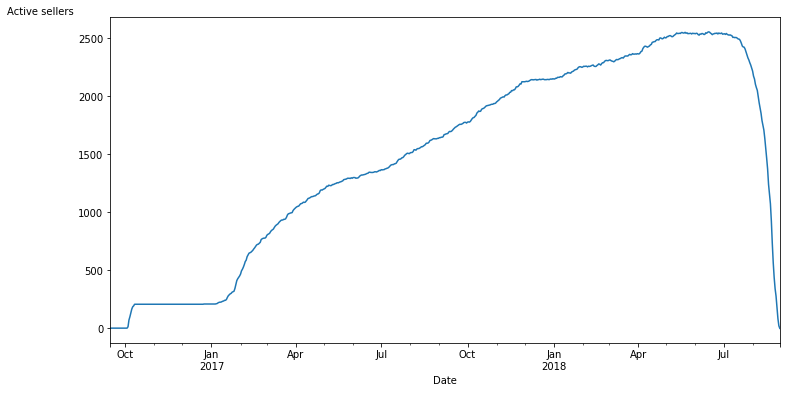

In [4]:
df.plot(figsize=(12, 6), legend=False)
plt.ylabel(ylabel="Active sellers", rotation=0, loc="top")

You can see that the slope (i.e. growth rate) is decreasing. Especially in early 2018 we added much fewer active sellers than in early 2017. Between Jan and Apr 2017, we added about 1,000 active sellers. However, during the same period in 2018, we only added mere 300 active sellers.

### Decreasing sales volume in 2018

Text(0.5, 1.0, 'The sales volume')

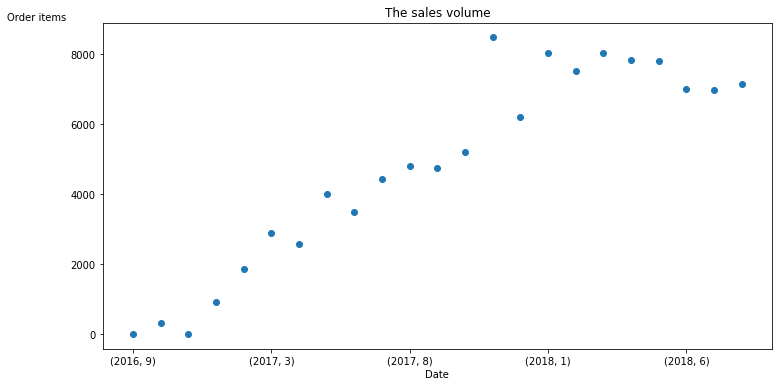

In [5]:
merged["year"] = merged['order_purchase_timestamp'].map(lambda x: x.date().year)
merged["month"] = merged['order_purchase_timestamp'].map(lambda x: x.date().month)
merged.groupby(["year", "month"]).order_id.count().plot(style="o", figsize=(12,6))
plt.ylabel(ylabel="Order items", rotation=0, loc="top")
plt.xlabel(xlabel="Date")
plt.title("The sales volume")

Text(0.5, 1.0, 'The average price')

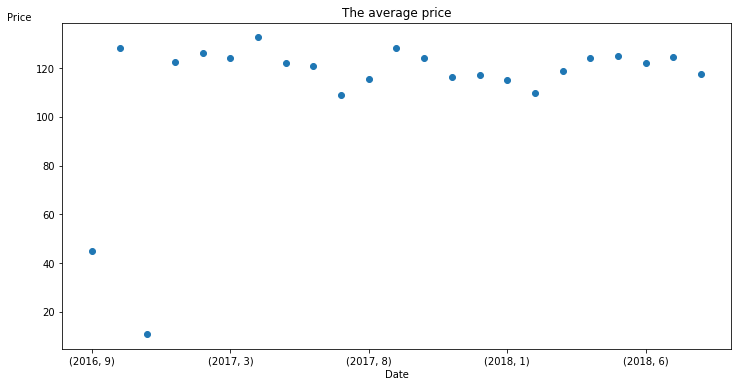

In [6]:
merged.groupby(["year", "month"]).price.mean().plot(style="o", figsize=(12,6))
plt.ylabel(ylabel="Price", rotation=0, loc="top")
plt.xlabel(xlabel="Date")
plt.title("The average price")

### Decreasing review score

In 2017, the average review score dropped from 4.5 to 4.0. The average score kept decreasing till March 2018 when it reached 3.75.

Text(0.5, 0, 'Date')

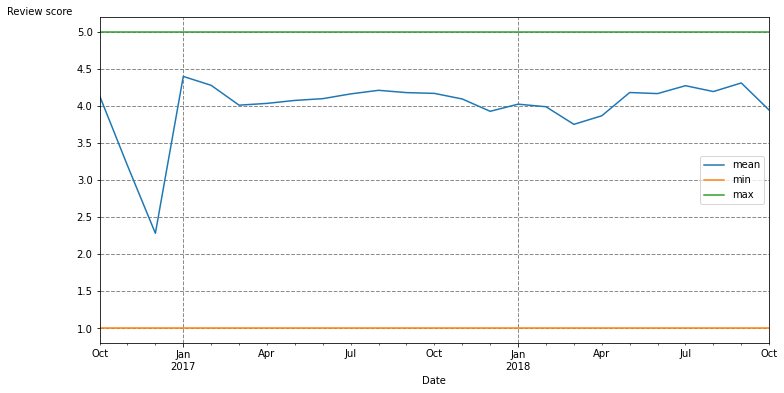

In [7]:
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv', parse_dates=["review_creation_date","review_answer_timestamp"])
reviews['year'] = reviews['review_answer_timestamp'].map(lambda x: x.date().year)
reviews['month'] = reviews['review_answer_timestamp'].map(lambda x: x.date().month)
reviews['day'] = 1
reviews["date"] = pd.to_datetime(reviews[["year", "month", "day"]])
reviews.set_index("date", inplace=True)
reviews.drop(['year', 'month', 'day'], axis=1, inplace=True)
reviews_monthly = reviews.resample("MS").agg(['mean', 'min', 'max'])
reviews_monthly.review_score.plot(figsize=(12, 6))
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Review score", rotation=0, loc="top")
plt.xlabel("Date")

### What are buyers complaining about?

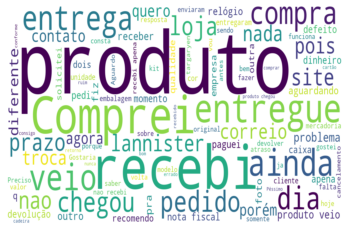

In [25]:
import wordcloud

stopwords = []
with open("stopwords.txt") as input_file:
    for line in input_file:
        stopwords.append(line.strip())

text = " ".join(review for review in reviews[reviews.review_score<3].dropna().review_comment_message)
wc = wordcloud.WordCloud(stopwords=stopwords, max_words=100, width=1600, height=800, background_color="white").generate(text)
wc.to_file("wordcloud.png")
plt.imshow(wc, interpolation='bilinear', aspect="auto")
plt.axis("off")
plt.show()

This shows the word cloud of the words in the reviews of review score less than three. I noticed that there are several words about delivery and arrival. For example, "recebi" (received), "entregue" (delivery), "entrega" (deliver), "chegou" (arrived), and ainda (not yet). This implies that logistics is the main pain point for the buyers. 

### Shorter average wait time less negative reviews

Text(0.5, 1.0, 'The distribution of review scores')

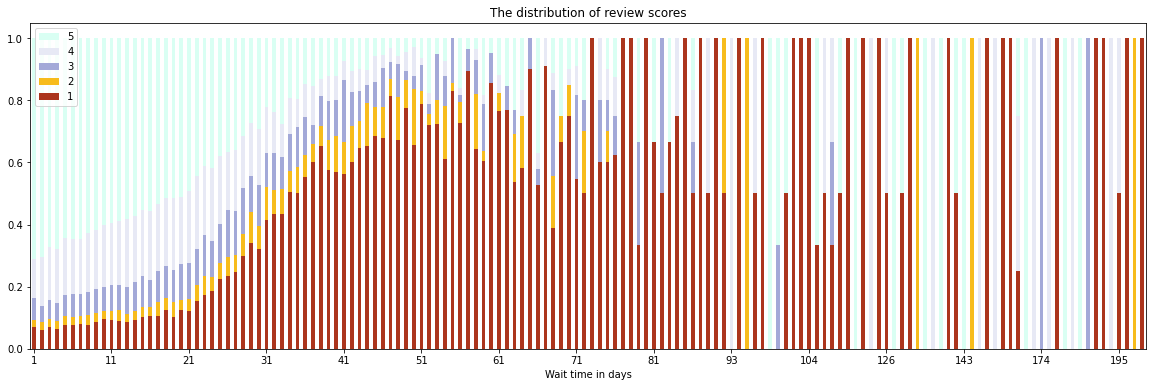

In [154]:
order_reviews = pd.merge(left=merged, right=reviews, left_on="order_id", right_on="order_id")
order_reviews["wait_time"] = (order_reviews.order_delivered_customer_date - order_reviews.order_purchase_timestamp)
order_reviews["wait_time_days"] = order_reviews["wait_time"].round("d").map(lambda x: x.days)

temp_df = order_reviews.groupby(["wait_time_days", "review_score"]).order_id.count()
result = {}
for index, row in temp_df.iteritems():
    if index[0] not in result:
        result[index[0]] = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    result[index[0]][index[1]] = row

result_df = []
for key, value in result.items():
    total = sum(value.values())
    if total > 0:
        new_value = {k: v/ total for k, v in value.items()}
    result_df.append({"wait_time_days": key, **new_value})
result_df = pd.DataFrame(result_df)
result_df.set_index("wait_time_days", inplace=True)
ax = result_df.plot(kind="bar", stacked=True,figsize=(20,6), rot=0, color=["#ab351d", "#f7bc1c", "#a3a9d8", "#e7e9f5", "#d9fff3"])
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left')
ax.set_xlabel("Wait time in days")
ax.set_title("The distribution of review scores")

1.371730755686956 -1.9888714783045116


Text(0, 1, 'Review score < 3 (%)')

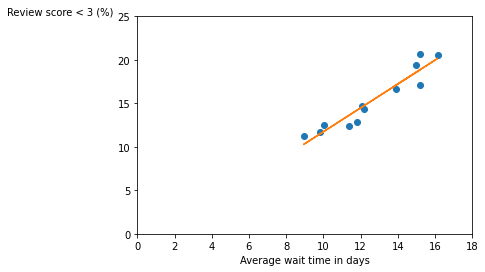

In [10]:
order_reviews["month"] = order_reviews["order_purchase_timestamp"].map(lambda x: x.date().month)
# define bad reviews as the review score less than 3
order_reviews["bad_reviews"] = np.where(order_reviews['review_score']<3, 1, 0)
# the percentage of bad reviews
bad_reviews_pct = order_reviews.groupby("month").bad_reviews.sum().div(order_reviews.groupby("month").order_id.count()) * 100

wait_time_days = order_reviews.groupby("month").wait_time_days.mean()
review_vs_wait_time = pd.concat([bad_reviews_pct, wait_time_days], axis=1)
review_vs_wait_time.columns = ["Bad reviews", "Wait time in days"]
x = review_vs_wait_time["Wait time in days"]
y = review_vs_wait_time["Bad reviews"]
m, b = np.polyfit(x, y, 1)
print(m, b)
plt.plot(x, y, 'o')
plt.plot(x, m*x + b)
plt.xlim(0, 18)
plt.ylim(0,25)
plt.xlabel("Average wait time in days")
plt.ylabel("Review score < 3 (%)", rotation=0, loc="top")


This graph indicates a positive linear relationship between average wait time and the proportion of the bad reviews. We estimate that if we decrease the average wait time by one day, we are expected to decrease the percentage of bad reviews by 1.37%

### Missed delivery estimates can negatively impact the reviews

Text(0.5, 1.0, 'The distribution of review scores')

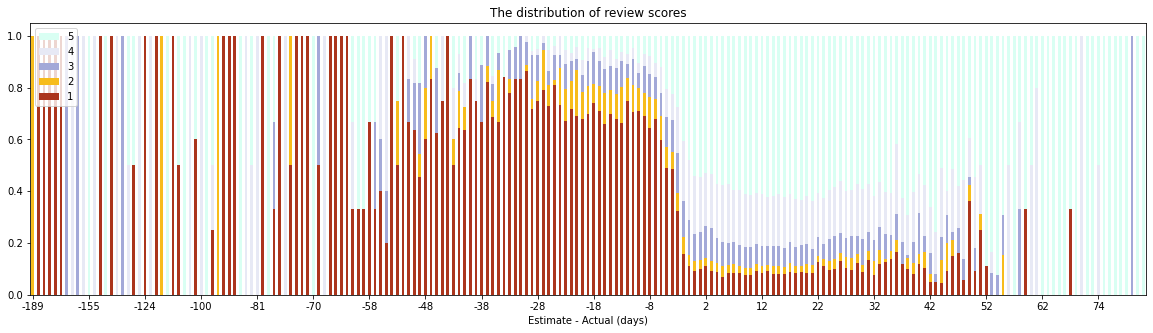

In [156]:
order_reviews["delta_estimate"] = (order_reviews.order_estimated_delivery_date - order_reviews.order_delivered_customer_date).round("d").map(lambda x: x.days)

temp_df = order_reviews.groupby(["delta_estimate", "review_score"]).order_id.count()
result = {}
for index, row in temp_df.iteritems():
    if index[0] not in result:
        result[index[0]] = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    result[index[0]][index[1]] = row

result_df = []
for key, value in result.items():
    total = sum(value.values())
    if total > 0:
        new_value = {k: v/ total for k, v in value.items()}
    result_df.append({"delta_estimate": key, **new_value})
result_df = pd.DataFrame(result_df)
result_df.set_index("delta_estimate", inplace=True)
ax = result_df.plot(kind="bar", stacked=True,figsize=(20,5), rot=0, color=["#ab351d", "#f7bc1c", "#a3a9d8", "#e7e9f5", "#d9fff3"])
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left')
ax.set_xlabel("Estimate - Actual (days)")
ax.set_title("The distribution of review scores")

0.6718467911188006 10.11117774922378


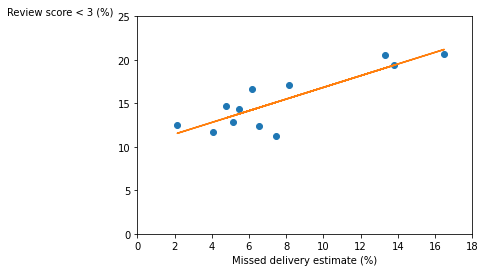

In [12]:
order_reviews["missed_estimate"] = np.where(order_reviews["order_estimated_delivery_date"] < order_reviews["order_delivered_customer_date"], 1, 0)
missed_estimate_pct = order_reviews.groupby("month").missed_estimate.sum().div(order_reviews.groupby("month").order_id.count()) * 100

review_vs_miss = pd.concat([bad_reviews_pct, missed_estimate_pct], axis=1)
review_vs_miss.columns = ["Bad reviews", "Missed estimate"]

x = review_vs_miss["Missed estimate"]
y = review_vs_miss["Bad reviews"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x + b)
plt.xlim(0, 18)
plt.ylim(0,25)
plt.xlabel("Missed delivery estimate (%)")
plt.ylabel("Review score < 3 (%)", rotation=0, loc="top")
print(m, b)

This graph indicates a positive linear relationship between the proportion of missing delivery estimates and the proportion of the bad reviews. We estimate that if we improve the accuracy of our delivery estimate by 1%, we are expected to decrease the percentage of bad reviews by 0.67%

Text(0, 1, 'Wait time (days)')

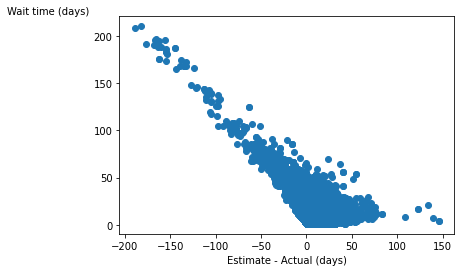

In [13]:
plt.plot(order_reviews["delta_estimate"], order_reviews["wait_time_days"], "o")
plt.xlabel("Estimate - Actual (days)")
plt.ylabel("Wait time (days)", rotation=0, loc="top")

**Caution**

As the above graph shows, there is a strong linear relationship between the wait time in days and (Estimate - actual) delivery dates. This might explain the linear relationship between the proportion of missing delivery estimates and the proportion of the bad reviews.

In [14]:
multi_linear = pd.concat([bad_reviews_pct, missed_estimate_pct, wait_time_days], axis=1)
multi_linear.columns = ["bad_review", "missed_estimate", "wait_time_days"]

import statsmodels.formula.api as sm

result = sm.ols(formula="bad_review ~ missed_estimate + wait_time_days", data=multi_linear).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             bad_review   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     89.46
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           1.15e-06
Time:                        16:13:06   Log-Likelihood:                -13.181
No. Observations:                  12   AIC:                             32.36
Df Residuals:                       9   BIC:                             33.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4520      1.584     

/Users/kyuseobkim/Codes/virtualenvs/dynasty_x86/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


From the above analysis, holding wait time in days constant, we expect to decrease the bad review percentage by 0.25% if we decrease the percentage of the missed estimate by 1%.

#### Missed delivery estimate percentage

In [15]:
order_reviews.missed_estimate.sum() / order_reviews.order_id.count() * 100

7.8994144237623045

We miss delivery estimates for about 8% of the entire orders

#### Review score summary statistics

In [16]:
order_reviews.groupby("seller_id").agg({"review_score": "mean"}).var()

review_score    0.655713
dtype: float64

In [17]:
order_reviews.groupby("seller_id").agg({"review_score": "mean"}).mean()

review_score    4.134942
dtype: float64

### We should send review requests after the delivery

In [67]:
order_reviews["review_answered_after"] = np.where(order_reviews.review_answer_timestamp > order_reviews.order_delivered_customer_date, 1, 0)

[Text(0, 0, 'before delivery'), Text(1, 0, 'after delivery')]

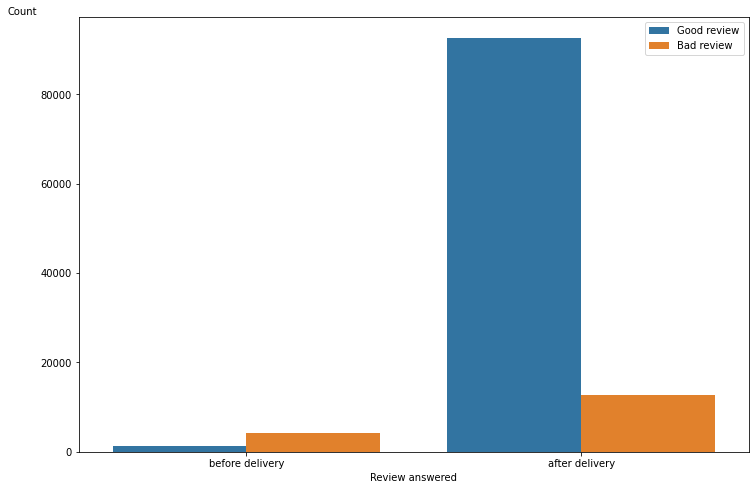

In [68]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="review_answered_after", hue="bad_reviews", data=order_reviews)
plt.xlabel("Review answered")
plt.ylabel("Count", loc="top", rotation=0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Good review", "Bad review"], loc='upper right')
ax.set_xticklabels(["before delivery", "after delivery"])


In [82]:
order_reviews[order_reviews.review_answered_after==1].bad_reviews.sum() / order_reviews[order_reviews.review_answered_after==1].order_id.count()

0.12005238235322029

In [84]:
order_reviews[order_reviews.review_answered_after==0].bad_reviews.sum() / order_reviews[order_reviews.review_answered_after==0].order_id.count()

0.7698092443140132

### Geography

In [27]:
sellers = pd.read_csv("data/olist_sellers_dataset.csv")

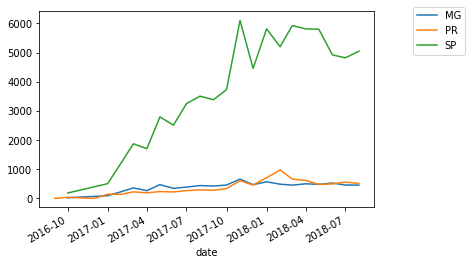

In [48]:
orders_sellers = pd.merge(left=merged, right=sellers, on="seller_id")
ctdf = (orders_sellers.reset_index()
          .groupby(['year',
                    'month', 'seller_state'], as_index=False).order_id
          .count()
       )
ctdf["day"] = 1
ctdf["date"] = pd.to_datetime(ctdf[["year", "month", "day"]])
fig, ax = plt.subplots()

# key gives the group name (i.e. ), data gives the actual values
for key, data in ctdf.groupby('seller_state'):
    if (data.order_id.max() > 600):
        data.plot(x='date', y='order_id', ax=ax, label=key)
ax.legend(bbox_to_anchor=(1.1, 1.05))

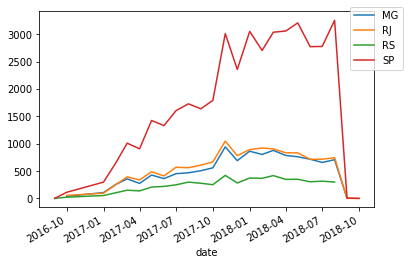

In [45]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders_customers = pd.merge(left=orders, right=customers, on="customer_id")
orders_customers["year"] = orders_customers.order_purchase_timestamp.map(lambda x: x.year)
orders_customers["month"] = orders_customers.order_purchase_timestamp.map(lambda x: x.month)

ctdf = (orders_customers.reset_index()
          .groupby(['year',
                    'month', 'customer_state'], as_index=False).order_id
          .count()
       )
ctdf["day"] = 1
ctdf["date"] = pd.to_datetime(ctdf[["year", "month", "day"]])
fig, ax = plt.subplots()

# key gives the group name (i.e. ), data gives the actual values
for key, data in ctdf.groupby('customer_state'):
    if (data.order_id.max() > 400):
        data.plot(x='date', y='order_id', ax=ax, label=key)
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [41]:
orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2


### The percentage of review requests created before the actual delivery

In [70]:
order_reviews["review_created_before"] = np.where(order_reviews.review_creation_date < order_reviews.order_delivered_customer_date, 1, 0)

In [74]:
order_reviews.review_created_before.sum() / order_reviews.review_created_before.count()

0.0841371096534363

In [78]:
order_reviews.shape

(110831, 30)

In [85]:
order_reviews.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_creation_date,review_answer_timestamp,wait_time,wait_time_days,bad_reviews,delta_estimate,missed_estimate,review_created_before,review_created_after,review_answered_after
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017-10-11,2017-10-12 03:43:48,8 days 10:28:40,8,0,7,0,0,1,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,...,2018-08-08,2018-08-08 18:37:50,13 days 18:46:08,14,0,5,0,0,1,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,...,2018-08-18,2018-08-22 19:07:58,9 days 09:27:40,9,0,17,0,0,1,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,2017-12-03,2017-12-05 19:21:58,13 days 05:00:36,13,0,13,0,0,1,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,...,2018-02-17,2018-02-18 13:02:51,2 days 20:58:23,3,0,9,0,0,1,1


In [87]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [91]:
order_items_reviews = pd.merge(left=order_items, right=reviews, on="order_id")
review_score_vol = order_items_reviews.groupby("seller_id").agg({"review_score": "mean", "order_id": "count"})

In [93]:
review_score_vol["nearest_five"] = review_score_vol.review_score.map(lambda x: 0.5 * round(x * 2))

In [98]:
review_score_vol.groupby("nearest_five").order_id.agg(["mean", np.std, "count"])

,mean,std,count
nearest_five,,,
1.0,1.810127,1.929166,158
1.5,6.125000,4.616998,16
2.0,6.588235,19.143852,51
2.5,8.841584,21.861717,101
3.0,11.527919,20.275286,197
3.5,42.830065,106.246684,306
4.0,77.259016,198.965496,915
4.5,32.696203,55.421819,711
5.0,3.739063,5.356088,640


Text(0, 1, 'Number of orders')

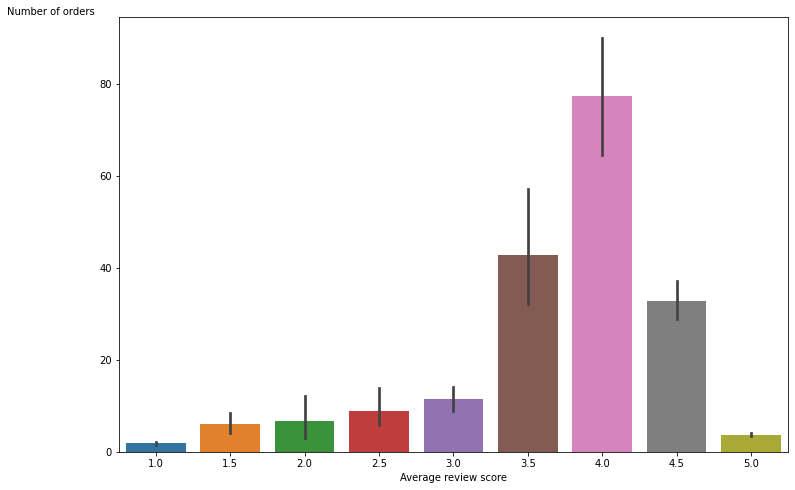

In [109]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x="nearest_five", y="order_id", data=review_score_vol)
ax.set_xlabel("Average review score")
ax.set_ylabel("Number of orders", rotation=0, loc="top")

In [111]:
orders["late"] = np.where(orders.order_estimated_delivery_date < orders.order_delivered_customer_date, 1, 0)

<AxesSubplot:xlabel='late', ylabel='count'>

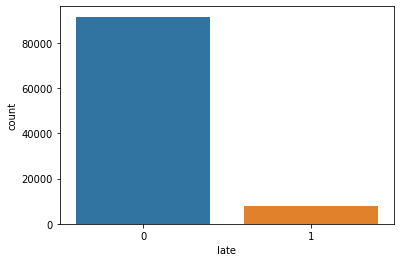

In [113]:
sns.countplot(x="late", data=orders)

In [117]:
orders["approval_time_delta"] = orders["order_approved_at"] - orders["order_purchase_timestamp"]
orders["carrier_time_delta"] = orders["order_delivered_carrier_date"] - orders["order_purchase_timestamp"]
orders["total_time_delta"] = orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]

In [121]:
orders["approval_time_delta_perc"] = orders.approval_time_delta / orders.total_time_delta * 100
orders["carrier_time_delta_perc"] = orders.carrier_time_delta / orders.total_time_delta * 100

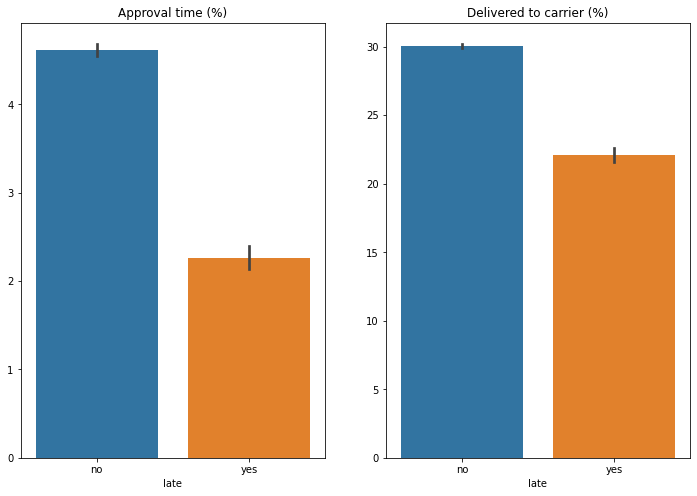

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(ax=ax1, x="late", y="approval_time_delta_perc", data=orders)
ax1.set_title("Approval time (%)")
ax1.set_xticklabels(["no", "yes"])
ax1.axes.get_yaxis().get_label().set_visible(False)
sns.barplot(ax=ax2, x="late", y="carrier_time_delta_perc", data=orders)
ax2.set_title("Delivered to carrier (%)")
ax2.set_xticklabels(["no", "yes"])
ax2.axes.get_yaxis().get_label().set_visible(False)

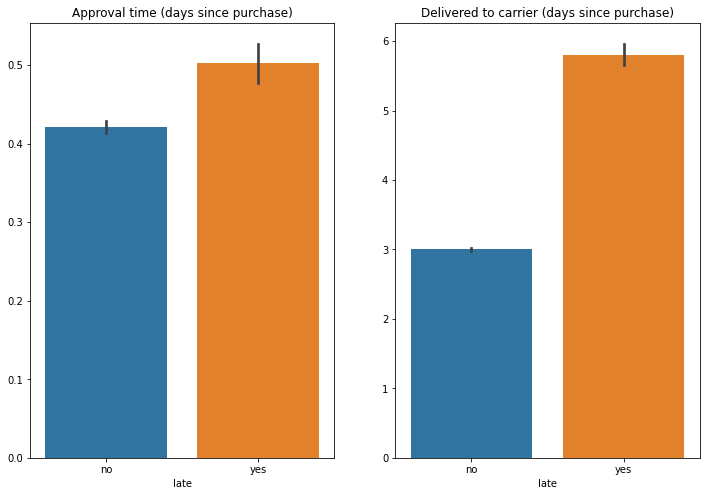

In [165]:
orders["approval_time_delta_days"] = orders["approval_time_delta"].round("d").map(lambda x: x.days)
orders["carrier_time_delta_days"] = orders["carrier_time_delta"].round("d").map(lambda x: x.days)

orders.groupby("late").agg({"approval_time_delta_days": ["mean", np.median], "carrier_time_delta_days": ["mean", np.median]})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(ax=ax1, x="late", y="approval_time_delta_days", data=orders)
ax1.set_title("Approval time (days since purchase)")
ax1.set_xticklabels(["no", "yes"])
ax1.axes.get_yaxis().get_label().set_visible(False)
sns.barplot(ax=ax2, x="late", y="carrier_time_delta_days", data=orders)
ax2.set_title("Delivered to carrier (days since purchase)")
ax2.set_xticklabels(["no", "yes"])
ax2.axes.get_yaxis().get_label().set_visible(False)

In [147]:
orders.groupby("late").agg({"approval_time_delta_days": ["mean", np.median], "carrier_time_delta_days": ["mean", np.median]})

approval_time_delta_days        carrier_time_delta_days       
                         mean median                    mean median
late                                                               
0                    0.420867    0.0                3.001436    2.0
1                    0.502108    0.0                5.806159    3.0

In [161]:
def draw_review_breakdown(merged_reviews, seller_id):
    reviews = merged_reviews[merged_reviews.seller_id==seller_id].sort_values(['order_purchase_timestamp'], ascending=False)
    reviews["month"] = reviews["order_purchase_timestamp"].map(lambda x: x.date().month)
    df_input = []
    result = {k: {1: 0, 2: 0, 3:0, 4:0, 5:0} for k in range(1,13)}
    flattened = reviews.groupby(["month", "review_score"]).order_id.count()
    for index, item in flattened.iteritems():
        result[index[0]][index[1]] = item

    for month, value in result.items():
        total = sum(value.values())
        if total > 0:
            new_value = {k: v/total for k, v in value.items()}
        else:
            new_value = value
        df_input.append({"month": month, **new_value})
    

    review_by_date = pd.DataFrame(df_input)
    ax = review_by_date.set_index("month").plot(figsize=(12,6),kind="bar", stacked=True, mark_right = True, rot=0, color=["#ab351d", "#f7bc1c", "#a3a9d8", "#e7e9f5", "#d9fff3"])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper left')
    ax.set_title("Sales in 2017")
    return review_by_date

,month,1,2,3,4,5
0,1,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000,1.000000
2,3,0.000000,0.000000,0.500000,0.000000,0.500000
3,4,0.000000,0.000000,0.125000,0.250000,0.625000
4,5,0.000000,0.000000,0.000000,0.000000,1.000000
5,6,0.000000,0.000000,0.142857,0.142857,0.714286
6,7,0.000000,0.000000,0.000000,0.142857,0.857143
7,8,0.000000,0.037037,0.000000,0.296296,0.666667
8,9,0.000000,0.000000,0.027027,0.270270,0.702703
9,10,0.057143,0.028571,0.085714,0.228571,0.600000


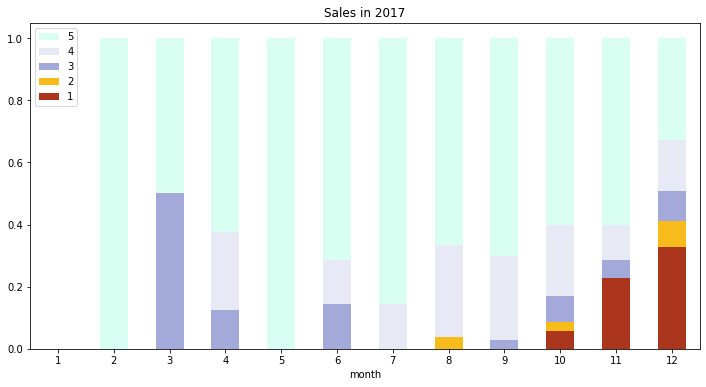

In [162]:
draw_review_breakdown(order_reviews, "7aa4334be125fcdd2ba64b3180029f14")